In [1]:
import pandas as pd
import lifelines 
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index 
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from collections import defaultdict
import numpy as np
import scipy.stats as stat
import os, time, sys, warnings, random
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
home_dir = os.path.expanduser('~')
exec(open('%s/AMB_ICI_prediction/toolbox/load_hierarchy.py'%home_dir).read())
exec(open('%s/AMB_ICI_prediction/toolbox/load_ICI.py'%home_dir).read())
exec(open('%s/AMB_ICI_prediction/toolbox/calculate_AMB_profiles.py'%home_dir).read())

In [2]:
## initalize
train_dataset = 'Samstein'
test_dataset = 'Hellmann'

In [3]:
# load datasets
data_df = {}
for dataset in [train_dataset, test_dataset]:
    mdf, pdf = load_ICI_data(dataset, 'mutation')
    mdf = mdf.rename(columns={'gene_id':'genes'})
    if dataset == 'Samstein':
        mdf = pd.DataFrame(data=mdf, columns=np.append(['genes'], list(set(mdf.columns) & set(pdf.loc[pdf['CANCER_TYPE'].isin(['Non-Small Cell Lung Cancer', 'Bladder Cancer']),:]['patient'].tolist()))))
        OS_months = [pdf.loc[pdf['patient']==sample,:]['OS_MONTHS'].tolist()[0] for sample in mdf.columns[1:]]
        OS_status = [pdf.loc[pdf['patient']==sample,:]['OS_STATUS'].tolist()[0] for sample in mdf.columns[1:]]
        OS_status = [1 if status=='1:DECEASED' else 0 for status in OS_status]
    data_df[dataset] = mdf

# genes
genes = data_df[train_dataset]['genes'].tolist()
data_df[test_dataset] = data_df[test_dataset].loc[data_df[test_dataset]['genes'].isin(genes),:]
tmp_genes = [gene for gene in genes if not gene in data_df[test_dataset]['genes'].tolist()] 
tmp_df = defaultdict(list)
for gene in tmp_genes:
    tmp_df['genes'].append(gene)
    for col in data_df[test_dataset].columns:
        if not col == 'genes':
            tmp_df[col].append(0)
tmp_df = pd.DataFrame(tmp_df)
data_df[test_dataset] = data_df[test_dataset].append(tmp_df)
    

/tmp/ipykernel_3480656/464321066.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df[test_dataset] = data_df[test_dataset].append(tmp_df)


Samstein Hellmann 0.8488377401281404


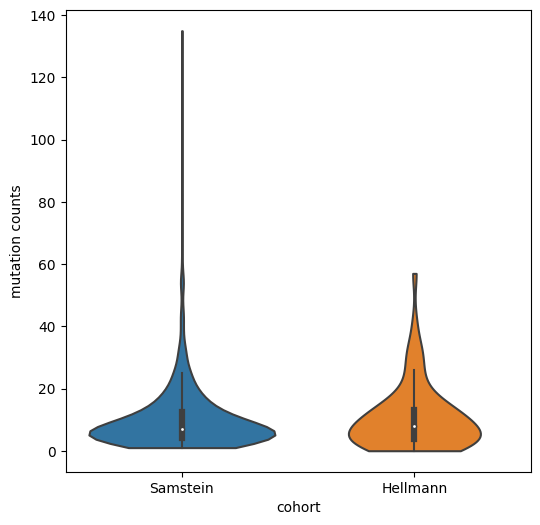

In [4]:
## distribution of mutational burden
import seaborn as sns
plot_df = defaultdict(list)
mut_burdens = []
datasets = [train_dataset, test_dataset]
for dataset in datasets:
    tmp_df = data_df[dataset]
    tmp = []
    for col in tmp_df.columns[1:]:
        tmp.append(tmp_df[col].sum())
        plot_df['cohort'].append(dataset)
        plot_df['mutation counts'].append(tmp_df[col].sum())
    mut_burdens.append(tmp); tmp = []
plot_df = pd.DataFrame(plot_df)

# draw distribution
plt.figure(figsize=(6,6))
sns.violinplot(data=plot_df, x='cohort', y='mutation counts', cut=0)
# statistical significance
for i,j in combinations(np.arange(len(mut_burdens)), 2):
    a,b = mut_burdens[i], mut_burdens[j]
    data1, data2 = datasets[i], datasets[j]
    _, pval = stat.mannwhitneyu(a,b)
print(data1, data2, pval)  
# display
plt.show()
plt.close()

 

In [5]:
## Calculate TMB profiles
hierarchy = 'NEST' 
AMB_profiles = {}
for dataset in datasets:
    tmp = Calculate_AMB_profiles(input_df=data_df[dataset], hierarchy=hierarchy).Simple_Sum()
    AMB_profiles[dataset] = tmp.sort_values(by='name')
    del tmp

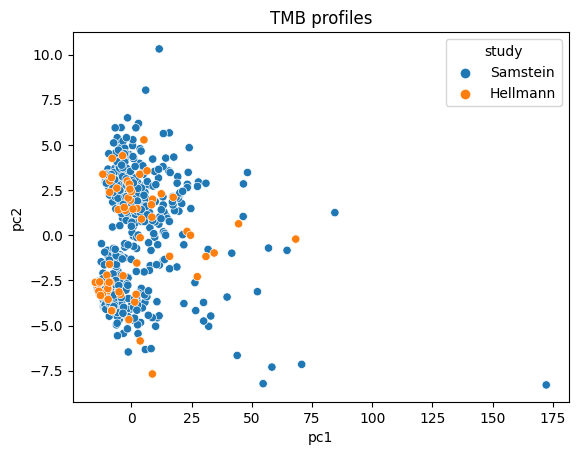

In [6]:
## PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)

# reorder data
x, x2 = {}, {}
y = []
for dataset in datasets:
    tmp_x, tmp_x2 = {}, {}
    tmp = AMB_profiles[dataset].sort_values(by='name').values[:,np.arange(1,AMB_profiles[dataset].shape[1])].T.astype(float)
    features = AMB_profiles[dataset].sort_values(by='name').values[:,0]
    for i in range(tmp.shape[1]):
        tmp_x[features[i]] = tmp[:,i]
    tmp_x = pd.DataFrame(tmp_x)

    if len(x) == 0:
        x = tmp_x
    else:
        x = pd.concat([x, tmp_x], axis=0)
    # y
    tmp_y = [dataset] * tmp_x.shape[0]
    y = np.append(y, tmp_y)
y = pd.DataFrame({'study':y})    

# pca
pc12 = pca.fit_transform(x)
pca_df = pd.DataFrame(data=pc12, columns=['pc1', 'pc2'])
final_df = pd.concat([pca_df, y], axis=1)

# plot 
sns.scatterplot(data=final_df, x='pc1', y='pc2', hue='study')
plt.title('TMB profiles')
plt.show()